<a href="https://colab.research.google.com/github/ShangWeiKuo/Portfolio/blob/main/Python/Classification/Multiclass/Wafer/Wafer_classification_Densenet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-plot

In [2]:
# loading libraries
import numpy as np # linear algebra
from numpy import argmax
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scikitplot as skplt
%matplotlib inline 

from keras.utils.np_utils import to_categorical
from keras import layers, Input, models
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import DenseNet201
from sklearn.metrics import classification_report

import cv2
from skimage import measure
from scipy import stats

import os
# set current working directory
path="/content/drive/MyDrive/wafer/"
os.chdir(path)

print(os.listdir(path))

import warnings
warnings.filterwarnings("ignore")

['LSWMD.pkl', 'wafer.zip', 'Untitled1.ipynb', 'wafer-defect-classification-by-deep-learning.ipynb', 'Wafer detection.ipynb', 'Wafer anomaly detection.ipynb', 'wafer_detection_densenet_model.h5', 'Wafer anomaly detection_AutoEncoder.ipynb', 'Wafer classification_Densenet201.ipynb', 'Wafer classification_KFold.ipynb']


In [3]:
df=pd.read_pickle("LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
df['waferIndex']
df = df.drop(['waferIndex'], axis = 1)

In [5]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
556999,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",733.0,lot34967,[],[],"(31, 31)"
402832,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,...",811.0,lot24134,[],[],"(34, 31)"
210768,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",14116.0,lot13454,[],[],"(212, 84)"
82878,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4188.0,lot5920,[],[],"(76, 71)"
548018,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot34314,[],[],"(49, 39)"


In [6]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [7]:
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_withpattern = df_withpattern.drop(columns=['dieSize', 'lotName'])

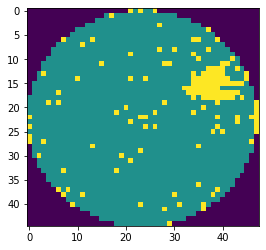

In [8]:
plt.imshow(df_withpattern.waferMap[0])
plt.show()

In [9]:
train_set = df_withpattern[df_withpattern['trianTestLabel'] == 'Training']
X_train = train_set['waferMap'].values
y_train = np.array(train_set['failureNum']).astype('float32')
y_train = to_categorical(y_train, num_classes=8)

In [10]:
X_train = train_set['waferMap']
y_train = np.array(train_set['failureNum']).astype('float32')
y_train = to_categorical(y_train, num_classes=8)

In [11]:
X_train = np.array([cv2.resize(img, dsize=(32,32)) for img in X_train])

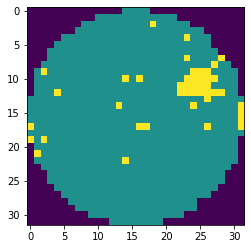

In [12]:
plt.imshow(X_train[0])
plt.show()

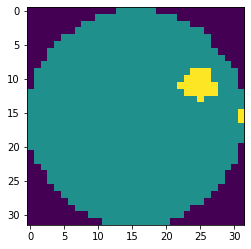

In [13]:
plt.imshow(cv2.medianBlur(X_train[0], 3))
plt.show()

In [14]:
X_train = X_train.reshape((-1, 32, 32, 1))

In [15]:
new_X_train = np.zeros((len(X_train), 32, 32, 3))

for w in range(len(X_train)):
    for i in range(32):
        for j in range(32):
            new_X_train[w, i, j, int(X_train[w, i, j])] = 1

In [16]:
# Conversion to float
new_X_train = new_X_train.astype('float32')
# X_test = X_test.astype('float32')

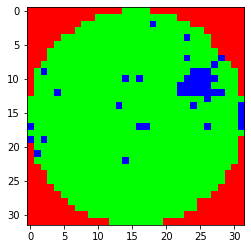

In [17]:
plt.imshow(new_X_train[0])
plt.show()

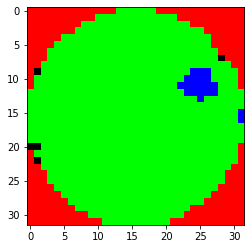

In [18]:
plt.imshow(cv2.medianBlur(new_X_train[0], 3))
plt.show()

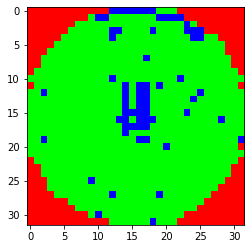

In [19]:
plt.imshow(new_X_train[train_set['failureNum']==0][0])
plt.show()

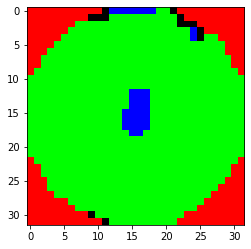

In [20]:
plt.imshow(cv2.medianBlur(new_X_train[train_set['failureNum']==0][0], 3))
plt.show()

In [21]:
X_train_copy = [ ]

for i in range(new_X_train.shape[0]):
  img = cv2.medianBlur(new_X_train[i], 3)
  X_train_copy.append(img)

X_train_copy = np.array(X_train_copy)

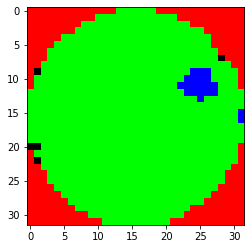

In [22]:
plt.imshow(X_train_copy[0])
plt.show()

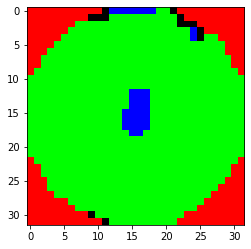

In [23]:
plt.imshow(X_train_copy[train_set['failureNum']==0][0])
plt.show()

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train_copy, y_train, test_size=0.2, random_state=2021)

In [25]:
def build_densenet():
    densenet = DenseNet201(weights='imagenet', include_top=False)

    input = Input(shape=(32, 32, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(8, activation = 'softmax')(x)
 
    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [26]:
model = build_densenet()
Reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=10)
checkpoint = ModelCheckpoint('wafer_detection_densenet_model.h5', verbose=1, save_best_only=True)

History = model.fit(X_train, y_train, 
            epochs=50, 
            batch_size=32,
            verbose=2,
            callbacks=[Reduce, es, checkpoint],
            validation_data=(X_val, y_val), 
            workers=8)

74850304/74836368 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 3)         84        
_________________________________________________________________
densenet201 (Functional)     (None, None, None, 1920)  18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
______________________________________________________________

In [27]:
score = model.evaluate(X_val, y_val)
print('Testing Accuracy:',score[1])

111/111 [==============================] - 7s 63ms/step - loss: 0.2168 - accuracy: 0.9387
Testing Accuracy: 0.9387233853340149


In [36]:
predictions = model.predict(X_val)
predictions = np.argmax(predictions > 0.5, axis=1)

In [29]:
# from numpy import argmax
# true = np.array([np.argmax(y, axis=None, out=None) for y in y_val])
true = np.argmax(y_val, axis=1)

In [31]:
# Confusion Matrix
print(classification_report(true, predictions))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       724
           1       0.93      0.78      0.85        73
           2       0.88      0.87      0.87       477
           3       0.98      0.99      0.98      1709
           4       0.83      0.83      0.83       310
           5       0.93      0.87      0.90       116
           6       0.78      0.38      0.51       105
           7       0.67      0.91      0.77        11

    accuracy                           0.93      3525
   macro avg       0.86      0.83      0.83      3525
weighted avg       0.93      0.93      0.92      3525



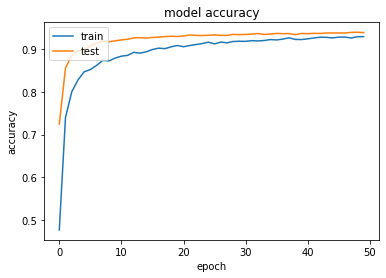

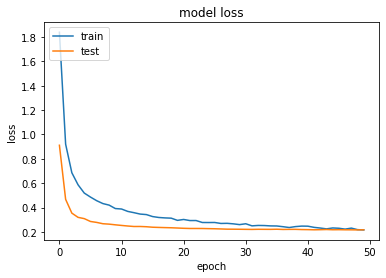

In [32]:
# accuracy plot 
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()